In [231]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time 
from tqdm.notebook import tqdm

In [232]:
from path_overlap import * 

In [3]:
num_dense, num_sparse = 3, 4
tot_units = num_dense + num_sparse
density = 1
num_layers = 3
MPG = multipartite_network(num_layers, num_dense, num_sparse, density)

In [4]:
pos = nx.multipartite_layout(MPG)

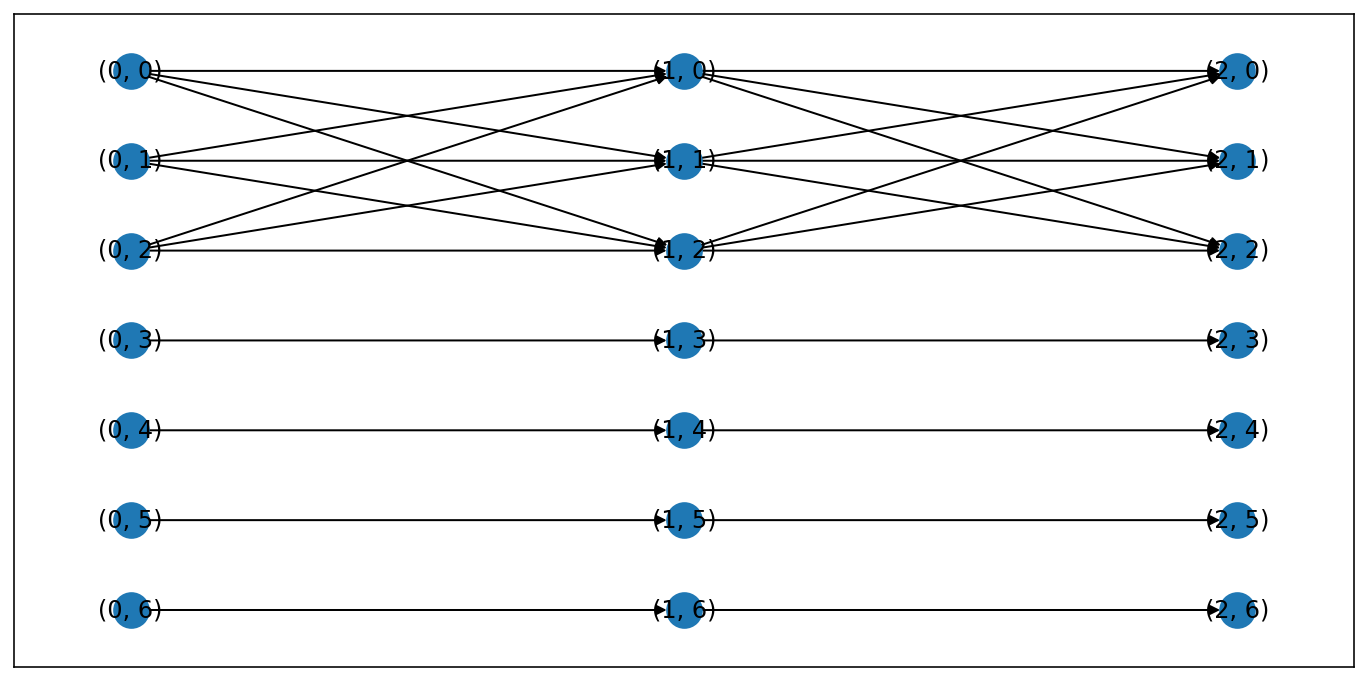

In [5]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(MPG, pos)

In [6]:
rew_MPG, counts = rewire_multipartite_network(MPG, tot_units, rewire_prob=.9, verbose=True, rewire_iters=100)

In [7]:
rew_pos = nx.multipartite_layout(rew_MPG)

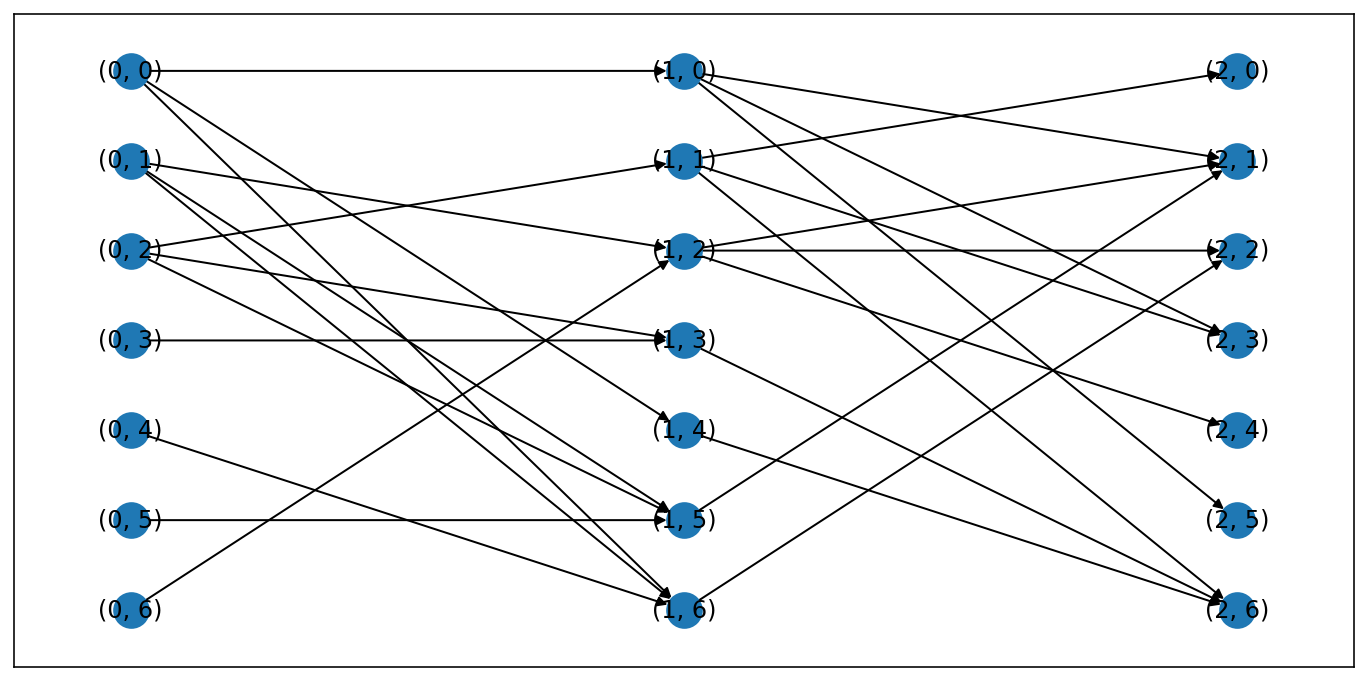

In [8]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(rew_MPG, pos)

In [9]:
from itertools import combinations, product
# output_nodes = [(num_layers-1, x) for x in range(tot_units)]
# input_nodes = [(0, x) for x in range(tot_units)]

# paths = {}
# for n, nn in product(input_nodes, output_nodes):
#     paths[(n, nn)] = list(nx.all_simple_paths(MPG, n, nn));
    
# rew_paths = {}
# for n, nn in product(input_nodes, output_nodes):
#     rew_paths[(n, nn)] = list(nx.all_simple_paths(rew_MPG, n, nn));

In [11]:
IG, paths = MP_interference_graph(MPG)
rew_IG, rew_paths = MP_interference_graph(rew_MPG)

In [12]:
IG.number_of_edges(), rew_IG.number_of_edges()

(36, 99)

5

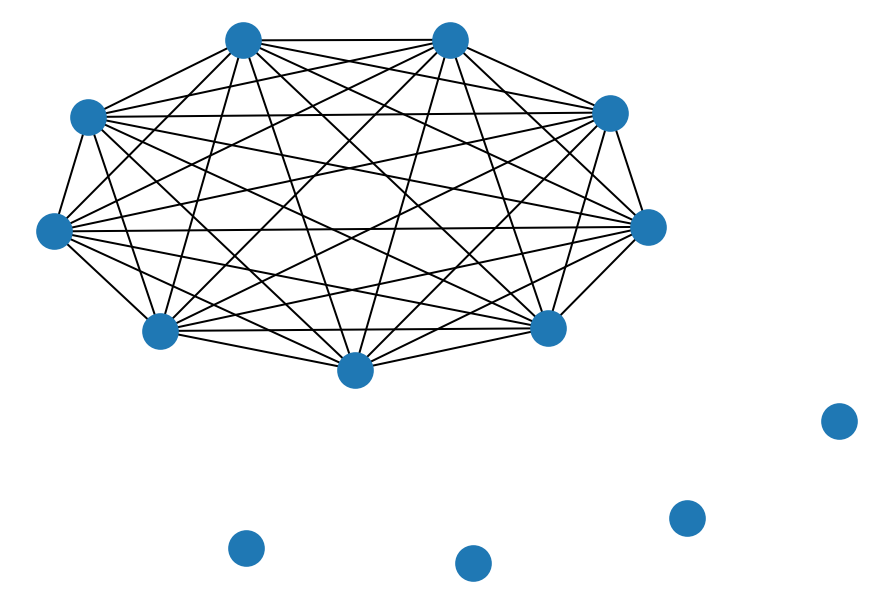

In [13]:
nx.draw_kamada_kawai(IG)
len(nx.maximal_independent_set(IG))

2

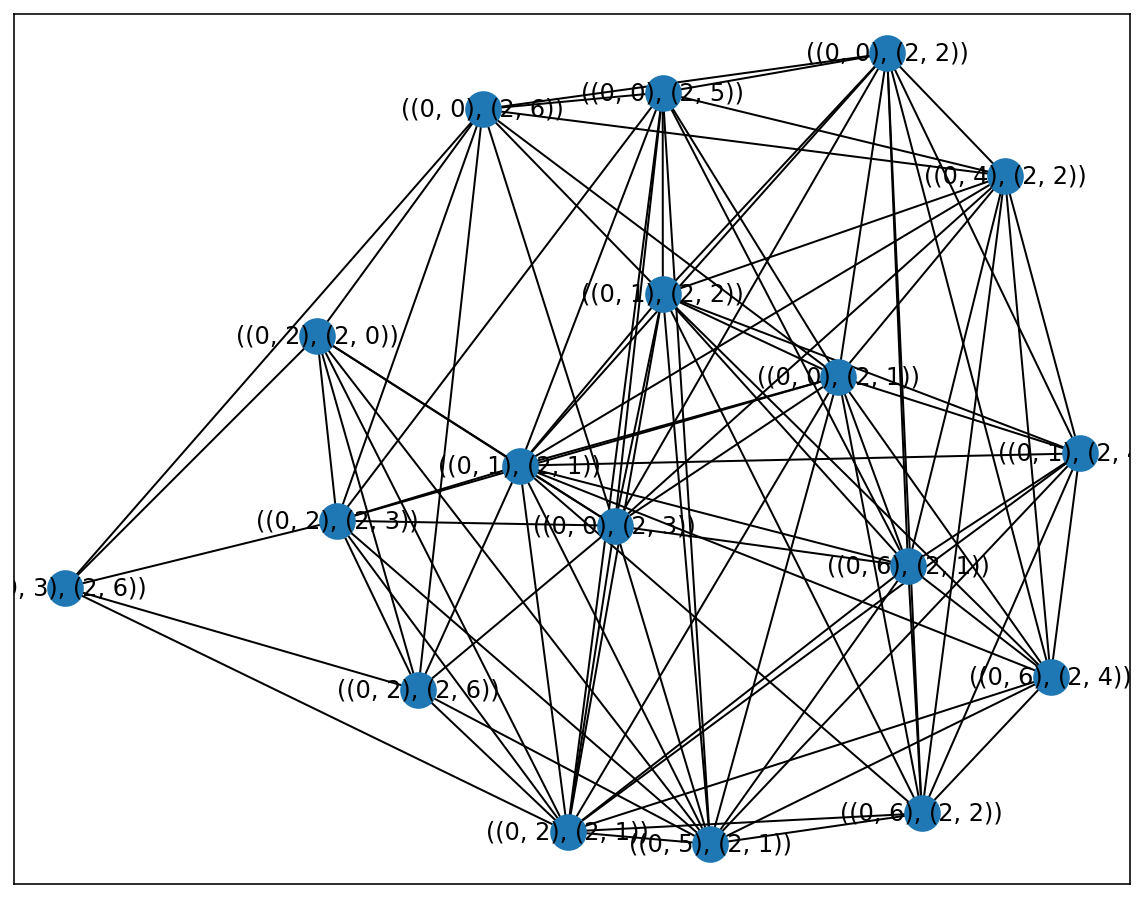

In [113]:
plt.figure(figsize=(10,8))
pos = nx.kamada_kawai_layout(rew_IG)
nx.draw_networkx(rew_IG, pos = pos)
len(nx.maximal_independent_set(rew_IG))

# let's try to sample and predict

In [15]:
import random
import graph_tool as gt

In [16]:
def sample_paths(graph, paths, num_samples, edge_obs=None):
    interference_data = []
    if edge_obs == None:
        edge_obs = {}
    while num_samples > 0:
        tf1, tf2 = sorted(random.choices(list(paths.keys()), k=2))
        p1, p2 = random.choice(paths[tf1]), random.choice(paths[tf2])
        if (tf1, tf2) in edge_obs:
            edge_obs[(tf1, tf2)]['measured'] += 1
        else:
            edge_obs[(tf1, tf2)] = {}
            edge_obs[(tf1, tf2)]['measured'] = 1
            edge_obs[(tf1, tf2)]['observed'] = 0
        if check_layer_level_interference(graph, p1, p2):
            edge_obs[(tf1, tf2)]['observed'] += 1
        num_samples-=1;
    return edge_obs;

In [17]:
rew_IG.number_of_nodes(), rew_IG.number_of_edges()

(18, 99)

In [24]:
relab_dict = dict(zip(list(rew_paths.keys()), range(len(rew_paths))))

In [52]:

def empirical_IG(edge_obs, rld, g=None):
    if g == None:
        g = gt.Graph()
        m = g.new_ep("int", 1)   # number of measurements
        o = g.new_ep("int", 0)   # number of observations

    for edge in edge_obs:
        e = g.add_edge(rld[edge[0]], rld[edge[1]])
        m[e] = edge_obs[edge]['measured']
        o[e] = edge_obs[edge]['observed']
    g.edge_properties['measured'] = m
    g.edge_properties['observed'] = o
    return g;


def reconstruct_network(g, wait=1000, niter=10, num_sweeps=10000, verbose=False):
    import numpy as np;
    from graph_tool.inference.uncertain_blockmodel import MeasuredBlockState, MixedMeasuredBlockState
    from graph_tool.inference.mcmc import mcmc_equilibrate
    # initial hierarchical partition
    bs = [g.get_vertices()] + [np.zeros(1)] * 5;

    state = MeasuredBlockState(g, n=g.edge_properties['measured'], n_default=1,
                               x=g.edge_properties['observed'], x_default=0, state_args=dict(bs=bs));

    # We will first equilibrate the Markov chain
    if verbose==True:
        print('Equilibrating...')
    mcmc_equilibrate(state, wait=wait, mcmc_args=dict(niter=niter));

    # Now we collect the marginals for exactly 100,000 sweeps, at
    # intervals of 10 sweeps:
    global pv, u;
    u = None              # marginal posterior edge probabilities
    pv = None             # marginal posterior group membership probabilities

    def collect_marginals(s):
        global pv, u, cs;
        u = s.collect_marginal(u);
        bstate = s.get_block_state();
        pv = bstate.levels[0].collect_vertex_marginals(pv);

    if verbose==True:
        print('Collecting marginals...')
    mcmc_equilibrate(state, force_niter=num_sweeps, mcmc_args=dict(niter=niter),
                        callback=collect_marginals);
#     eprob = u.ep.eprob;
    return state, u, pv

In [96]:
edge_obs_test = sample_paths(rew_MPG, rew_paths, 100)

In [97]:
emp_g = empirical_IG(edge_obs_test, relab_dict);

In [98]:
print(emp_g.num_vertices(), emp_g.num_edges())

18 73


In [57]:
state, u, pv = reconstruct_network(emp_g, wait = 1000, num_sweeps=1000, niter=10, verbose=True);

Equilibrating...


In [58]:
eprob = u.ep.eprob

In [59]:
for edge in u.edges():
    print(edge, eprob[edge])

(0, 8) 1.0
(0, 11) 1.0
(0, 12) 1.0
(1, 9) 1.0
(1, 11) 1.0
(1, 8) 1.0
(1, 10) 1.0
(1, 14) 1.0
(1, 12) 1.0
(2, 6) 1.0
(2, 16) 1.0
(2, 17) 1.0
(2, 12) 1.0
(2, 7) 1.0
(2, 11) 1.0
(3, 11) 1.0
(3, 7) 1.0
(3, 12) 1.0
(3, 16) 1.0
(3, 6) 1.0
(3, 17) 1.0
(4, 6) 1.0
(4, 14) 1.0
(4, 15) 1.0
(4, 5) 1.0
(4, 9) 1.0
(4, 17) 1.0
(4, 16) 1.0
(4, 7) 1.0
(5, 11) 1.0
(5, 8) 1.0
(5, 10) 1.0
(5, 12) 1.0
(6, 11) 1.0
(6, 8) 1.0
(6, 12) 1.0
(6, 10) 1.0
(7, 11) 1.0
(7, 12) 1.0
(7, 10) 1.0
(7, 8) 1.0
(8, 16) 1.0
(8, 13) 1.0
(8, 17) 1.0
(8, 15) 1.0
(9, 13) 1.0
(9, 3) 1.0
(9, 5) 1.0
(10, 4) 1.0
(10, 15) 1.0
(10, 9) 1.0
(10, 17) 1.0
(10, 6) 1.0
(10, 16) 1.0
(11, 13) 1.0
(11, 15) 1.0
(11, 16) 1.0
(11, 17) 1.0
(11, 5) 1.0
(11, 8) 1.0
(12, 17) 1.0
(12, 13) 1.0
(12, 9) 1.0
(12, 15) 1.0
(12, 16) 1.0
(12, 3) 1.0
(12, 5) 1.0
(12, 14) 1.0
(12, 7) 1.0
(12, 6) 1.0
(12, 10) 1.0
(13, 14) 1.0
(13, 4) 1.0
(14, 9) 1.0
(15, 11) 1.0
(15, 12) 1.0
(16, 11) 1.0
(16, 15) 1.0
(17, 5) 1.0


In [60]:
rl_rew_IG = nx.relabel_nodes(rew_IG, relab_dict)

In [61]:
len(in_IG), len(not_in_IG), emp_g.num_edges(), rew_IG.number_of_edges()

(99, 72, 171, 99)

In [62]:
not_in_IG, in_IG = [], []
for edge in emp_g.edges():
    if (emp_g.vertex_index[edge.source()], emp_g.vertex_index[edge.target()]) not in rl_rew_IG.edges():
        not_in_IG.append(eprob[edge])
        print(edge, 'not in')
    else:
        in_IG.append(eprob[edge])
        print(edge, 'in')

(0, 13) in
(0, 16) in
(0, 0) not in
(0, 8) not in
(0, 2) in
(0, 14) in
(0, 10) in
(0, 15) in
(0, 12) not in
(0, 17) in
(0, 1) in
(0, 11) not in
(0, 7) in
(0, 9) in
(0, 3) in
(0, 4) in
(0, 5) in
(0, 6) in
(1, 10) not in
(1, 3) in
(1, 11) not in
(1, 7) in
(1, 15) in
(1, 14) not in
(1, 13) in
(1, 8) not in
(1, 17) in
(1, 1) not in
(1, 2) in
(1, 4) in
(1, 9) not in
(1, 6) in
(1, 5) in
(1, 12) not in
(1, 16) in
(2, 13) in
(2, 7) not in
(2, 4) in
(2, 14) in
(2, 3) in
(2, 12) not in
(2, 5) in
(2, 17) not in
(2, 2) not in
(2, 8) in
(2, 9) in
(2, 10) in
(2, 6) in
(2, 16) not in
(2, 15) in
(2, 11) in
(3, 7) not in
(3, 8) not in
(3, 9) in
(3, 13) in
(3, 12) not in
(3, 6) in
(3, 5) in
(3, 15) in
(3, 4) in
(3, 11) not in
(3, 17) not in
(3, 14) in
(3, 16) not in
(3, 10) in
(3, 3) not in
(4, 10) in
(4, 5) not in
(4, 16) not in
(4, 7) not in
(4, 11) in
(4, 9) not in
(4, 6) in
(4, 14) not in
(4, 4) not in
(4, 17) not in
(4, 12) in
(4, 8) in
(4, 15) not in
(4, 13) in
(5, 10) in
(5, 6) in
(5, 14) in
(5, 

(0.0, 0.0)

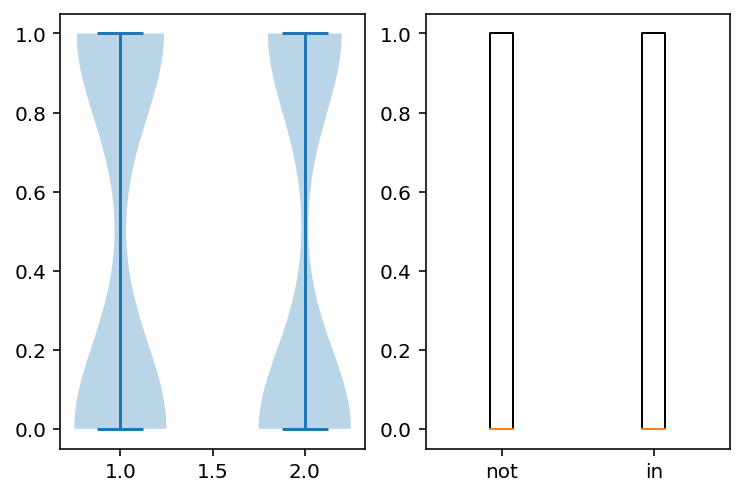

In [63]:
plt.subplot(121) 
plt.violinplot([not_in_IG, in_IG])#, labels=['not', 'in']);
plt.subplot(122)
plt.boxplot([not_in_IG, in_IG], labels=['not', 'in']);
np.median(np.array(not_in_IG)), np.median(np.array(in_IG))

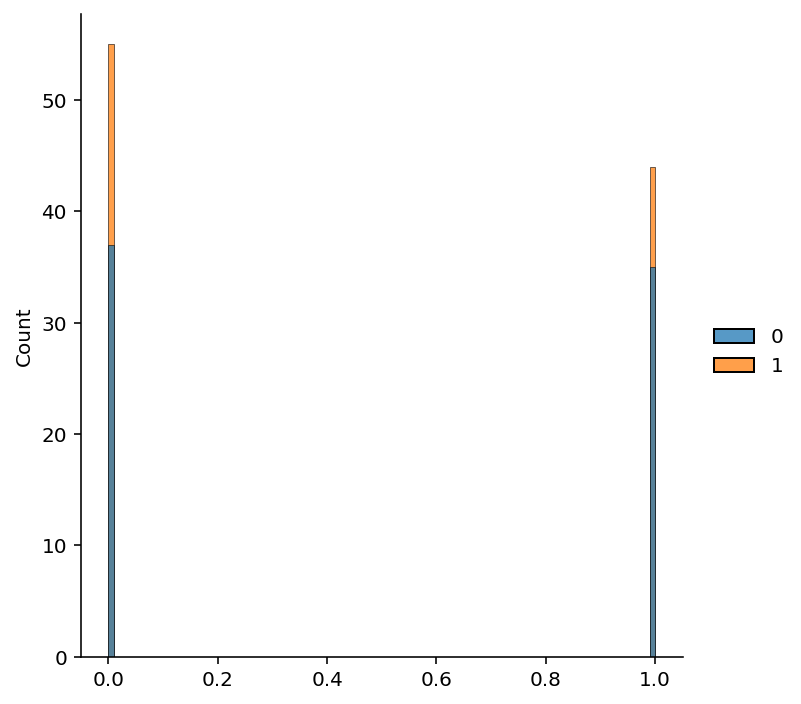

In [64]:
import seaborn as sns
sns.displot([not_in_IG, in_IG], bins=np.linspace(0,1,100))

In [65]:
import cellbell
cellbell.ding()

In [73]:
# simple prediction

In [100]:
[print(edge) for edge in emp_g.edges()]

(0, 6)
(0, 17)
(0, 0)
(0, 3)
(0, 8)
(0, 9)
(0, 10)
(0, 2)
(0, 4)
(1, 8)
(1, 6)
(1, 5)
(1, 11)
(1, 10)
(1, 4)
(1, 12)
(1, 16)
(1, 7)
(1, 14)
(2, 3)
(2, 5)
(2, 9)
(2, 8)
(2, 16)
(2, 13)
(2, 4)
(2, 11)
(3, 6)
(3, 4)
(3, 3)
(3, 10)
(3, 15)
(3, 12)
(3, 17)
(4, 5)
(4, 6)
(4, 11)
(4, 7)
(5, 7)
(5, 17)
(5, 11)
(5, 10)
(6, 17)
(6, 7)
(6, 15)
(6, 8)
(6, 14)
(7, 16)
(7, 13)
(7, 8)
(7, 15)
(7, 17)
(7, 14)
(7, 9)
(8, 14)
(8, 15)
(8, 9)
(8, 10)
(8, 11)
(8, 12)
(9, 10)
(9, 13)
(9, 14)
(9, 11)
(10, 13)
(10, 17)
(10, 10)
(10, 14)
(11, 17)
(12, 15)
(12, 17)
(14, 15)
(17, 17)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [99]:
emp_g.num_edges()
gt.inference.minimize_nested_blockmodel_dl

73

In [228]:
g = emp_g.copy()

L = 10
dehstate = gt.inference.minimize_nested_blockmodel_dl(g, deg_corr=True)
bs = dehstate.get_bs()                     # Get hierarchical partition.
bs += [np.zeros(1)] * (L - len(bs))     # Augment it to L = 10 with
                                        # single-group levels.
dehstate = dehstate.copy(bs=bs, sampling=True)

In [224]:
import networkx as nx
import pyintergraph

nx_emp_g = pyintergraph.igraph2nx(pyintergraph.gt2igraph(g))#, labelname="index"))
inv_relab_dict = dict(zip(relab_dict.values(), relab_dict.keys()))
nx_emp_g = nx.relabel_nodes(nx_emp_g, inv_relab_dict)

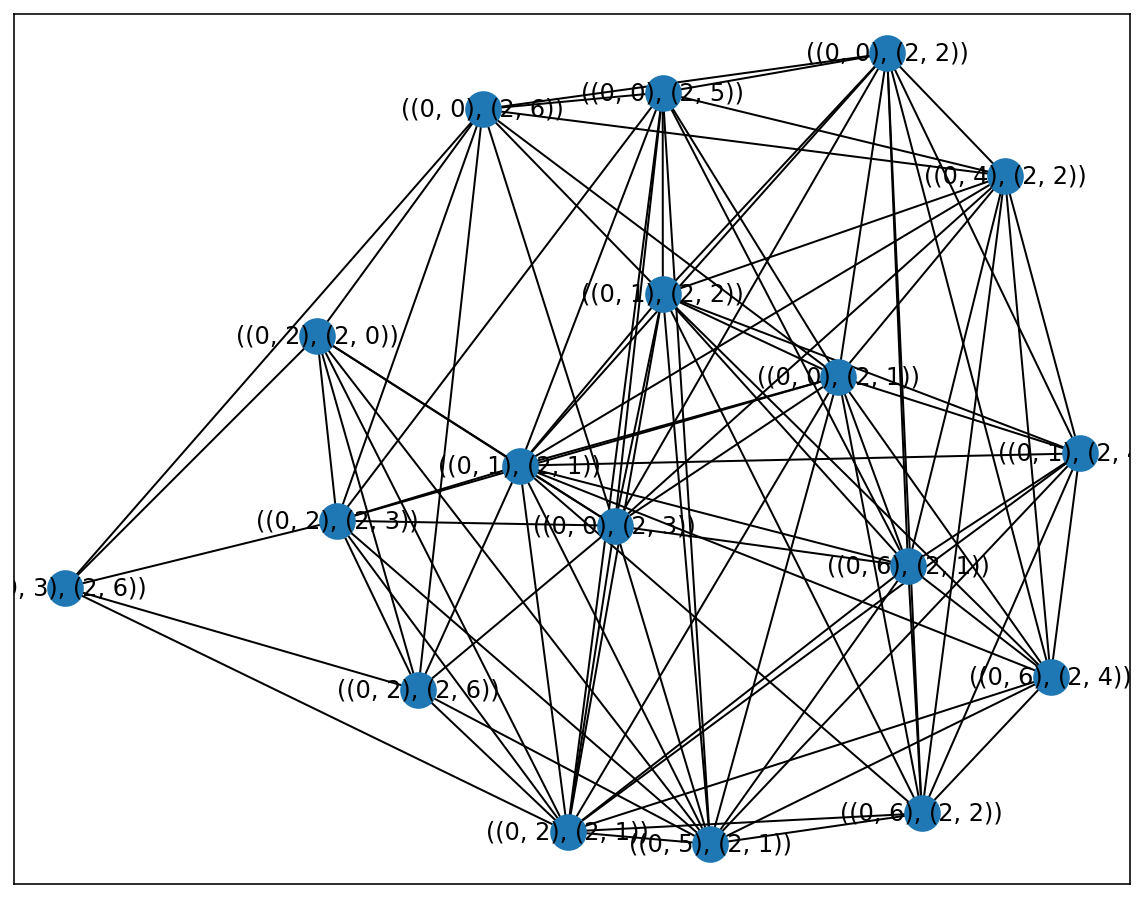

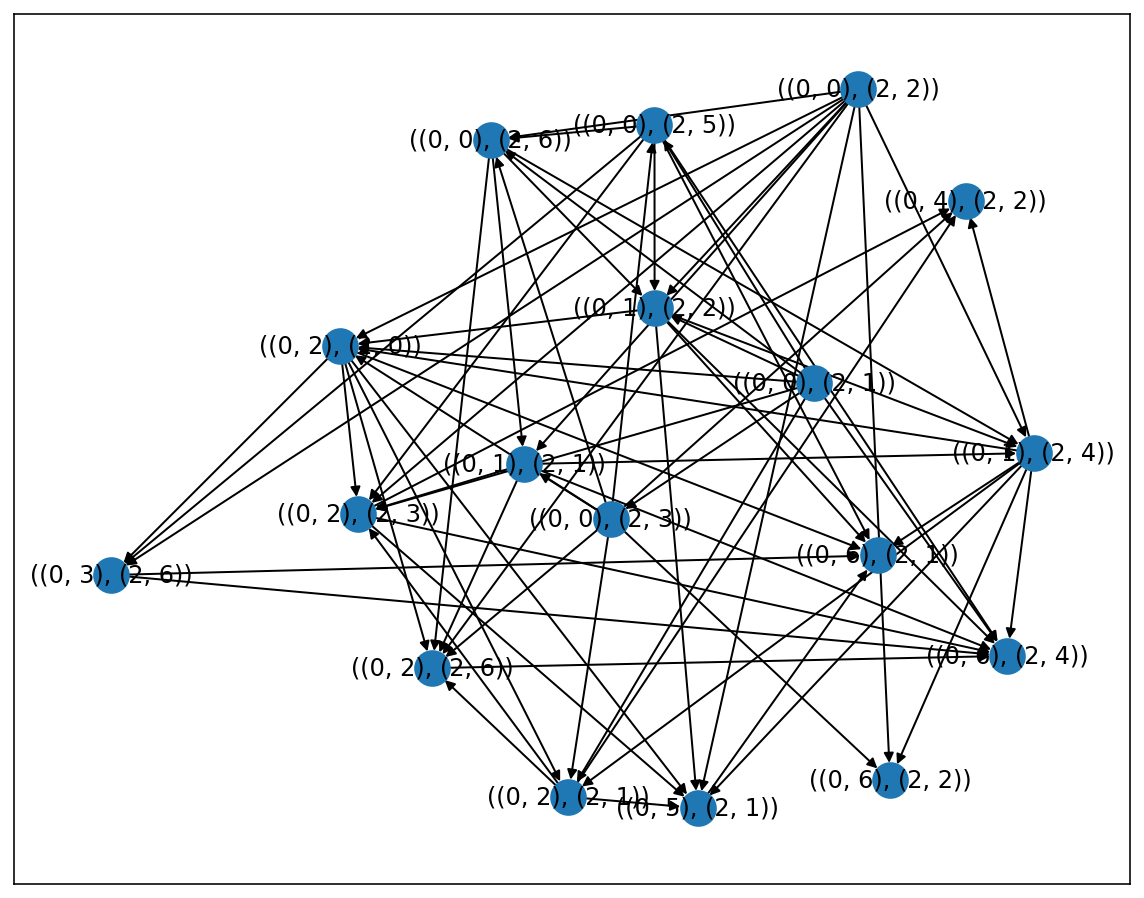

In [225]:
plt.figure(figsize=(10,8))
pos = nx.kamada_kawai_layout(rew_IG)
nx.draw_networkx(rew_IG, pos = pos)

plt.figure(figsize=(10,8))
nx.draw_networkx(nx_emp_g, pos = pos)


In [166]:
candidate_missing_edges = []
for edge in rew_IG.edges():
    if edge not in nx_emp_g.edges():
        candidate_missing_edges.append((relab_dict[edge[0]], relab_dict[edge[1]]));
        
candidate_complement_edges = [(relab_dict[edge[0]], relab_dict[edge[1]]) for edge in nx.complement(rew_IG).edges()]
len(candidate_complement_edges), len(candidate_missing_edges)

(54, 50)

In [167]:
missing_edges = list(map(tuple,candidate_missing_edges));
missing_edges.extend(list(map(tuple,candidate_complement_edges)))

In [169]:
probs = [];
for i in range(len(missing_edges)):
    probs.append([])
probs = tuple(probs)

In [190]:
def collect_edge_probs(s):
    for i in range(len(missing_edges)):
        p = s.get_edges_prob([missing_edges[i]], entropy_args=dict(partition_dl=False))
        probs[i].append(p)

# Now we collect the probabilities for exactly 100,000 sweeps
gt.inference.mcmc_equilibrate(dehstate, force_niter=1000, mcmc_args=dict(niter=10),
                    callback=collect_edge_probs)

(161.67468294892288, 4534136, 40328)

In [218]:
def get_avg(p):
   p = np.array(p)
   pmax = p.max()
   p -= pmax
   return pmax + np.log(np.exp(p).mean())

pis = {}
for i, prob in enumerate(probs):
    inv_edge = (inv_relab_dict[missing_edges[i][0]], inv_relab_dict[missing_edges[i][1]])
    pis[inv_edge] = get_avg(probs[i])

p_sum = get_avg(list(pis.values())) + np.log(len(missing_edges))

for edge in pis:
    pis[edge] = pis[edge] - p_sum

# print("likelihood-ratio for %s: %g" % (missing_edges[0], np.exp(l1)))
# print("likelihood-ratio for %s: %g" % (missing_edges[1], np.exp(l2)))

In [219]:
for edge in pis:
    print("likelihood-ratio for %s: %g" % (edge, np.exp(pis[edge])))

likelihood-ratio for (((0, 0), (2, 1)), ((0, 0), (2, 2))): 0.00514564
likelihood-ratio for (((0, 0), (2, 1)), ((0, 1), (2, 1))): 0.0308711
likelihood-ratio for (((0, 0), (2, 1)), ((0, 1), (2, 4))): 0.0128682
likelihood-ratio for (((0, 0), (2, 1)), ((0, 4), (2, 2))): 0.0128671
likelihood-ratio for (((0, 0), (2, 1)), ((0, 5), (2, 1))): 0.00900876
likelihood-ratio for (((0, 0), (2, 1)), ((0, 6), (2, 1))): 0.0180151
likelihood-ratio for (((0, 0), (2, 1)), ((0, 6), (2, 2))): 0.0205821
likelihood-ratio for (((0, 0), (2, 2)), ((0, 0), (2, 3))): 0.00566159
likelihood-ratio for (((0, 0), (2, 2)), ((0, 0), (2, 5))): 0.0226385
likelihood-ratio for (((0, 0), (2, 2)), ((0, 4), (2, 2))): 0.0141539
likelihood-ratio for (((0, 0), (2, 2)), ((0, 6), (2, 1))): 0.0198162
likelihood-ratio for (((0, 0), (2, 2)), ((0, 6), (2, 4))): 0.0283091
likelihood-ratio for (((0, 0), (2, 3)), ((0, 1), (2, 2))): 0.0231495
likelihood-ratio for (((0, 0), (2, 3)), ((0, 2), (2, 3))): 0.0370385
likelihood-ratio for (((0, 0), 

In [220]:

candidate_missing_edges_probs = []
for edge in rew_IG.edges():
    if edge not in nx_emp_g.edges():
        candidate_missing_edges_probs.append(np.exp(pis[edge]));

candidate_complement_edges_probs = []        
for edge in nx.complement(rew_IG).edges():
    candidate_complement_edges_probs.append(np.exp(pis[edge]));

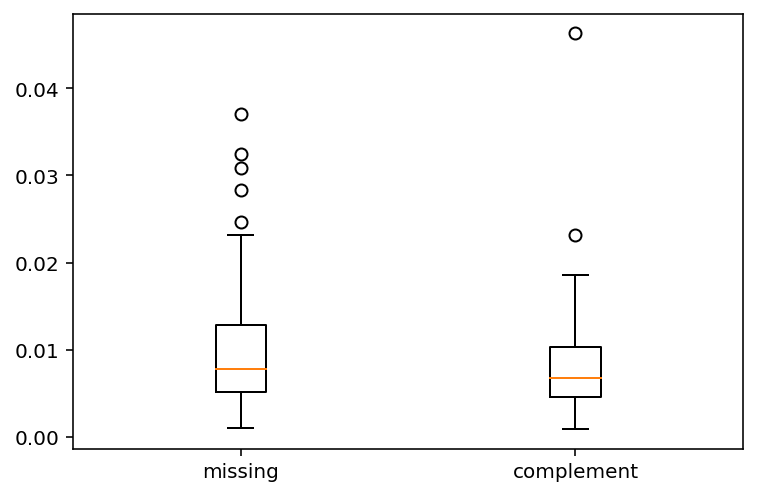

In [221]:
plt.boxplot([candidate_missing_edges_probs, candidate_complement_edges_probs], 
            labels=['missing', 'complement']);


In [229]:
from scipy.stats import mannwhitneyu, ks_2samp
mannwhitneyu(candidate_missing_edges_probs, candidate_complement_edges_probs), ks_2samp(candidate_missing_edges_probs, candidate_complement_edges_probs)

(MannwhitneyuResult(statistic=1210.5, pvalue=0.18290658646884195),
 KstestResult(statistic=0.14296296296296296, pvalue=0.5978448980687856))

In [223]:
import cellbell 
cellbell.ding()